In [60]:
import sys
sys.path.append('/home/elilouis/data-processing/')

In [61]:
import functions_library

In [66]:
import glob
import numpy as np
import pandas as pd
import xarray as xr
import pytz
import matplotlib.pyplot as plt

from metpy.units import units
from metpy.calc import add_height_to_pressure
from sublimpy import utils

# SoS Run

## Load SoS Data

In [63]:
start_date = '20221130'
end_date = '20230517'

tidy_dataset_fn = f"../sos/tidy_df_30Min_{start_date}_{end_date}_noplanar_fit.parquet"
tidy_dataset_5min_fn = f"../sos/tidy_df_{start_date}_{end_date}_noplanar_fit.parquet"
tidy_daily_dataset_output_fn = f"tidy_df_daily_{start_date}_{end_date}_noplanar_fit.parquet"

tidy_df_30Min = pd.read_parquet(
        tidy_dataset_fn
    )
tidy_df_30Min['time'] = pd.to_datetime(tidy_df_30Min['time'])

## Prep inputs for the SPLASH algorithm

In [72]:
sos_inputs_df = tidy_df_30Min[tidy_df_30Min.variable.isin(
    ['spd_3m_c', 'Tsurf_c', 'T_3m_c', 'mixingratio_3m_c', 'P_10m_c', 'SnowDepth_d', 'w_h2o__3m_c', 'w_tc__3m_c']
)][['time', 'variable', 'value']].set_index('time').pivot(columns='variable')
sos_inputs_df.columns = sos_inputs_df.columns.droplevel()
# adjust pressure from 10m to 3m
sos_inputs_df['P_10m_c'] = add_height_to_pressure(
    sos_inputs_df['P_10m_c'].values * units("millibar"), 
    -7 * units("m")
)

sos_inputs_df

variable,P_10m_c,SnowDepth_d,T_3m_c,Tsurf_c,mixingratio_3m_c,spd_3m_c,w_h2o__3m_c,w_tc__3m_c
time,,,,,,,,
2022-11-29 17:00:00,713.792945,0.334301,-12.797492,-12.455597,0.001308,3.323426,0.001584,-0.033430
2022-11-29 17:30:00,714.061632,0.334301,-13.050861,-12.947398,0.000996,4.556745,0.001530,-0.073341
2022-11-29 18:00:00,714.645873,0.334301,-13.382802,-13.572779,0.000960,3.731591,-0.000297,-0.056730
2022-11-29 18:30:00,715.315696,0.334301,-14.988197,-15.405741,0.001019,1.838974,0.000404,-0.001789
2022-11-29 19:00:00,715.797976,0.334301,-16.329076,-16.812970,0.001059,1.354227,-0.000359,-0.016223
...,...,...,...,...,...,...,...,...
2023-05-17 15:30:00,721.849041,0.000000,13.910910,20.356776,0.004260,4.693956,0.033596,0.066067
2023-05-17 16:00:00,721.730598,0.000000,13.517461,18.503993,0.004521,4.374811,0.029292,0.051201
2023-05-17 16:30:00,721.596520,0.000000,13.357073,17.582565,0.004395,4.092707,0.025573,0.030231


In [73]:
INVERSION_HEIGHT = 600
SOS_INSTRUMENT_HEIGHT = 3

output_var_names = [
    'hsb', 'hlb', 'tau', 'zo', 'zot', 'zoq', 'L', 'usr', 'tsr', 'qsr', 'dter', 'dqer', \
        'hl_webb', 'Cd', 'Ch', 'Ce', 'Cdn_10', 'Chn_10', 'Cen_10', 'rr', 'rt', 'rq', 
]

## Run the SPLASH algorithm

In [74]:
# INPUTS get parsed like this:
# u  = bulk_input[0] # wind speed                         (m/s)
# ts = bulk_input[1] # bulk water/ice surface tempetature (degC)
# t  = bulk_input[2] # air temperature                    (degC) 
# Q  = bulk_input[3] # air moisture mixing ratio          (kg/kg)
# zi = bulk_input[4] # inversion height                   (m)
# P  = bulk_input[5] # surface pressure                   (mb)
# zu = bulk_input[6] # height of anemometer               (m)
# zt = bulk_input[7] # height of thermometer              (m)
# zq = bulk_input[8] # height of hygrometer               (m)
sos_results_list = []
for time, row in sos_inputs_df.iterrows():
    bulk_inputs = [
        row['spd_3m_c'],
        row['Tsurf_c'],
        row['T_3m_c'],
        row['mixingratio_3m_c'],
        INVERSION_HEIGHT,
        row['P_10m_c'],
        SOS_INSTRUMENT_HEIGHT - row['SnowDepth_d'],
        SOS_INSTRUMENT_HEIGHT - row['SnowDepth_d'],
        SOS_INSTRUMENT_HEIGHT - row['SnowDepth_d']
    ]
    try:
        bulk_outputs = functions_library.cor_ice_A10(bulk_inputs)
        sos_results_list.append(bulk_outputs)
    except:
        print(f"Failed on timestamp: {time}")
        sos_results_list.append(np.full(len(output_var_names), np.nan))

sos_results_df = pd.DataFrame(sos_results_list)
sos_results_df.columns = output_var_names
sos_results_df['time'] = sos_inputs_df.index
sos_results_df = sos_results_df.set_index('time')

Failed on timestamp: 2023-01-17 08:00:00
Failed on timestamp: 2023-01-17 08:30:00
Failed on timestamp: 2023-01-17 09:00:00
Failed on timestamp: 2023-01-17 09:30:00
Failed on timestamp: 2023-01-17 10:00:00
Failed on timestamp: 2023-01-17 10:30:00
Failed on timestamp: 2023-01-17 11:00:00
Failed on timestamp: 2023-01-17 11:30:00
Failed on timestamp: 2023-01-17 12:00:00
Failed on timestamp: 2023-01-17 12:30:00
Failed on timestamp: 2023-01-17 13:00:00
Failed on timestamp: 2023-03-11 00:00:00
Failed on timestamp: 2023-03-11 00:30:00
Failed on timestamp: 2023-03-11 01:00:00
Failed on timestamp: 2023-03-11 01:30:00
Failed on timestamp: 2023-03-11 02:00:00
Failed on timestamp: 2023-03-11 02:30:00
Failed on timestamp: 2023-03-11 03:00:00
Failed on timestamp: 2023-03-11 03:30:00
Failed on timestamp: 2023-03-11 04:00:00
Failed on timestamp: 2023-03-11 04:30:00
Failed on timestamp: 2023-03-11 05:00:00
Failed on timestamp: 2023-03-11 05:30:00
Failed on timestamp: 2023-03-11 06:00:00
Failed on timest

## Convert w/m^2 to g/m^2/s

In [75]:
latent_heat_of_vaporization = 2838 * units("J/g")
sos_results_df['hlb_gperm2s'] = sos_results_df['hlb'] / latent_heat_of_vaporization

<Axes: xlabel='time'>

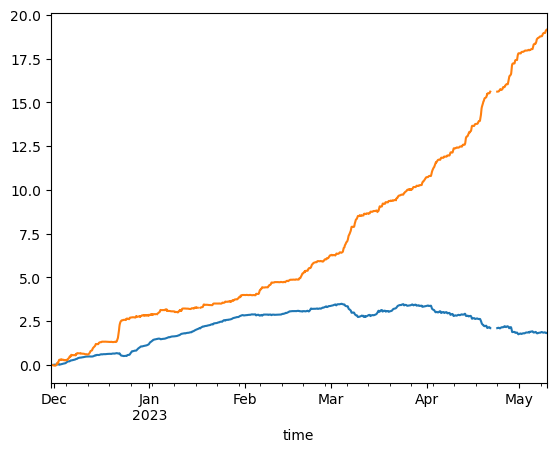

In [89]:
(-sos_results_df['hlb_gperm2s']).loc['20221130':'20230509'].cumsum().plot()
sos_inputs_df['w_h2o__3m_c'].loc['20221130':'20230509'].cumsum().plot()

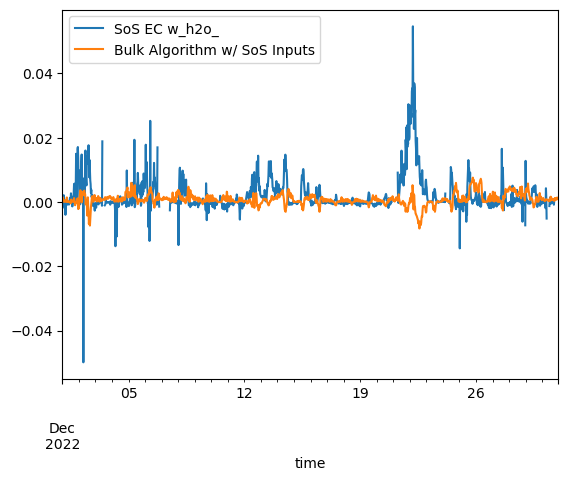

In [91]:
sos_inputs_df['w_h2o__3m_c'].loc['20221201': '20221230'].plot(label = 'SoS EC w_h2o_')
(-sos_results_df['hlb_gperm2s']).loc['20221201': '20221230'].plot(label = 'Bulk Algorithm w/ SoS Inputs')
plt.legend()

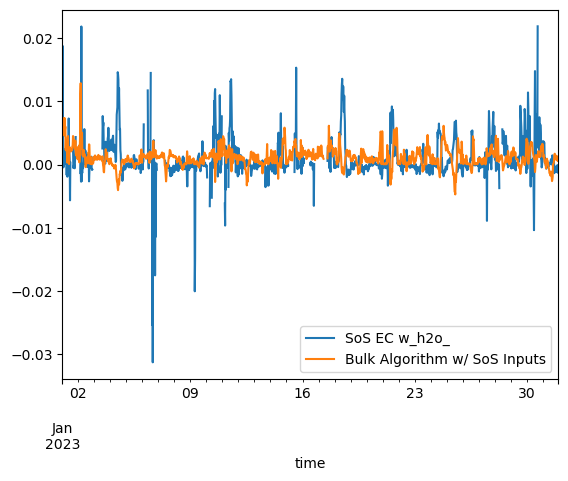

In [92]:
sos_inputs_df['w_h2o__3m_c'].loc['20230101': '20230131'].plot(label = 'SoS EC w_h2o_')
(-sos_results_df['hlb_gperm2s']).loc['20230101': '20230131'].plot(label = 'Bulk Algorithm w/ SoS Inputs')
plt.legend()

# SPLASH Run

## Load SPLASH data

In [93]:
splash_inputs_ds = xr.open_mfdataset(glob.glob(
    "/storage/elilouis/sublimationofsnow/asfs/kps/sledseb**202212**.nc"
))

In [94]:
splash_inputs_df = splash_inputs_ds[[
    'snow_depth',
    'skin_temp_surface',
    'wspd_vec_mean',
    'temp',
    'mixing_ratio',
    'atmos_pressure',
    'Hl',
    'bulk_Hl'
]].to_dataframe().resample('30Min').mean()
splash_inputs_df = utils.modify_df_timezone(splash_inputs_df.reset_index(), pytz.UTC, pytz.timezone("US/Mountain")).set_index('time')
# fill missing snow depth values, which there are a lot of, these the backfill method
splash_inputs_df.snow_depth = splash_inputs_df.snow_depth.interpolate(method='bfill')
# convert snow depth from cm to m
splash_inputs_df.snow_depth = splash_inputs_df.snow_depth/100
# convert mixing ratio from g/kg to g/g which is the same as kg/kg
splash_inputs_df.mixing_ratio = splash_inputs_df.mixing_ratio/1000

/tmp/ipykernel_12861/1972664044.py:13: FutureWarning: Series.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  splash_inputs_df.snow_depth = splash_inputs_df.snow_depth.interpolate(method='bfill')


In [95]:
splash_inputs_df.head()

,snow_depth,skin_temp_surface,wspd_vec_mean,temp,mixing_ratio,atmos_pressure,Hl,bulk_Hl
time,,,,,,,,
2022-11-30 17:00:00,0.912985,-18.204987,1.154649,-8.708028,0.002180,718.996897,NaN,-0.370409
2022-11-30 17:30:00,0.912985,-17.793823,2.234186,-9.110089,0.002152,719.100820,NaN,-3.060032
2022-11-30 18:00:00,0.214775,-17.329864,2.748810,-8.923498,0.002185,719.160747,NaN,-5.508866
2022-11-30 18:30:00,0.214775,-17.818763,2.665918,-10.198465,0.002042,719.158327,NaN,-4.161898
2022-11-30 19:00:00,0.214775,-17.733451,2.900786,-10.410170,0.001975,719.239617,NaN,-4.921060


In [96]:
SPLASH_ANEMOMETER_HEIGHT = 4.62
SPLASH_THERMOMETER_HEIGHT = 2.89
SPLASH_HYGROMETER_HEIGHT = 2.8

In [97]:
splash_results_list = []
for time, row in splash_inputs_df.iterrows():
    bulk_inputs = [
        row['wspd_vec_mean'],
        row['skin_temp_surface'],
        row['temp'],
        row['mixing_ratio'],
        INVERSION_HEIGHT,
        row['atmos_pressure'],
        SPLASH_ANEMOMETER_HEIGHT - row['snow_depth'],
        SPLASH_THERMOMETER_HEIGHT - row['snow_depth'],
        SPLASH_HYGROMETER_HEIGHT - row['snow_depth']
    ]
    try:
        bulk_outputs = functions_library.cor_ice_A10(bulk_inputs)
        splash_results_list.append(bulk_outputs)
    except:
        print(f"Failed on timestamp: {time}")
        splash_results_list.append(np.full(len(output_var_names), np.nan))

splash_results_df = pd.DataFrame(splash_results_list)
splash_results_df.columns = output_var_names
splash_results_df = splash_results_df
splash_results_df.index = splash_inputs_df.index

Failed on timestamp: 2022-12-04 05:30:00
Failed on timestamp: 2022-12-04 06:00:00
Failed on timestamp: 2022-12-04 06:30:00
Failed on timestamp: 2022-12-04 07:00:00
Failed on timestamp: 2022-12-04 07:30:00
Failed on timestamp: 2022-12-04 08:00:00
Failed on timestamp: 2022-12-04 09:00:00
Failed on timestamp: 2022-12-12 17:00:00
Failed on timestamp: 2022-12-12 17:30:00
Failed on timestamp: 2022-12-12 18:00:00
Failed on timestamp: 2022-12-12 18:30:00
Failed on timestamp: 2022-12-12 19:00:00
Failed on timestamp: 2022-12-12 19:30:00
Failed on timestamp: 2022-12-12 20:00:00
Failed on timestamp: 2022-12-12 20:30:00
Failed on timestamp: 2022-12-12 21:00:00
Failed on timestamp: 2022-12-12 21:30:00
Failed on timestamp: 2022-12-12 22:00:00
Failed on timestamp: 2022-12-12 22:30:00
Failed on timestamp: 2022-12-12 23:00:00
Failed on timestamp: 2022-12-12 23:30:00
Failed on timestamp: 2022-12-13 00:00:00
Failed on timestamp: 2022-12-13 00:30:00
Failed on timestamp: 2022-12-13 01:00:00
Failed on timest

(-50.0, 50.0)

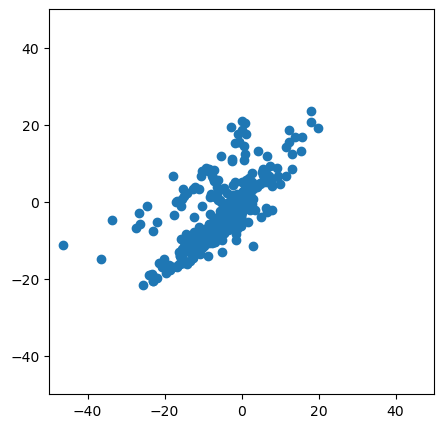

In [98]:
plt.figure(figsize=(5,5))
plt.scatter(
    splash_results_df['hlb'].loc['20221201':'20221230'],
    sos_results_df['hlb'].loc['20221201':'20221230'],    
)
plt.gca().set_aspect('equal')
plt.xlim(-50, 50)
plt.ylim(-50, 50)

# Compare SPLASH and SOS measurements/inputs

Text(0, 0.5, 'Snow depth (m)')

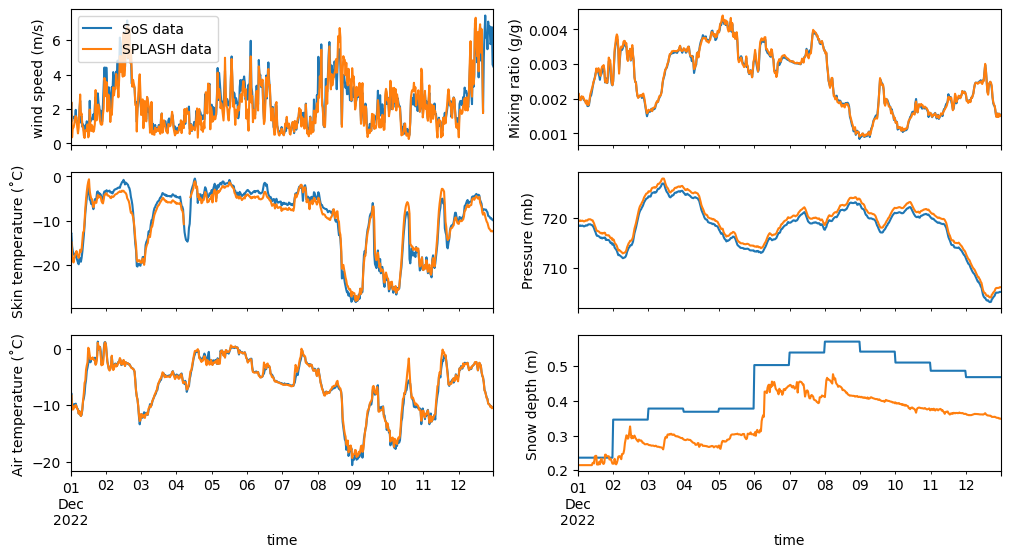

<Figure size 600x300 with 0 Axes>

In [99]:
fig, axes = plt.subplots(3, 2, figsize = (12, 6), sharex=True)
plt.figure(figsize=(6,3))

sos_inputs_df['spd_3m_c'].loc['20221201': '20221212'].plot(ax=axes[0,0], label='SoS data')
splash_inputs_df['wspd_vec_mean'].loc['20221201': '20221212'].plot(ax=axes[0,0], label='SPLASH data')
axes[0,0].set_ylabel("wind speed (m/s)")
axes[0,0].legend()

sos_inputs_df['Tsurf_c'].loc['20221201': '20221212'].plot(ax=axes[1,0])
splash_inputs_df['skin_temp_surface'].loc['20221201': '20221212'].plot(ax=axes[1,0])
axes[1,0].set_ylabel("Skin temperature (˚C)")

sos_inputs_df['T_3m_c'].loc['20221201': '20221212'].plot(ax=axes[2,0])
splash_inputs_df['temp'].loc['20221201': '20221212'].plot(ax=axes[2,0])
axes[2,0].set_ylabel("Air temperature (˚C)")

sos_inputs_df['mixingratio_3m_c'].loc['20221201': '20221212'].plot(ax=axes[0,1])
splash_inputs_df['mixing_ratio'].loc['20221201': '20221212'].plot(ax=axes[0,1])
axes[0,1].set_ylabel("Mixing ratio (g/g)")

sos_inputs_df['P_10m_c'].loc['20221201': '20221212'].plot(ax=axes[1,1])
splash_inputs_df['atmos_pressure'].loc['20221201': '20221212'].plot(ax=axes[1,1])
axes[1,1].set_ylabel("Pressure (mb)")

sos_inputs_df['SnowDepth_d'].loc['20221201': '20221212'].plot(ax=axes[2,1])
splash_inputs_df['snow_depth'].loc['20221201': '20221212'].plot(ax=axes[2,1])
axes[2,1].set_ylabel("Snow depth (m)")


Text(0, 0.5, 'Temperature difference (SoS - SPLASH)')

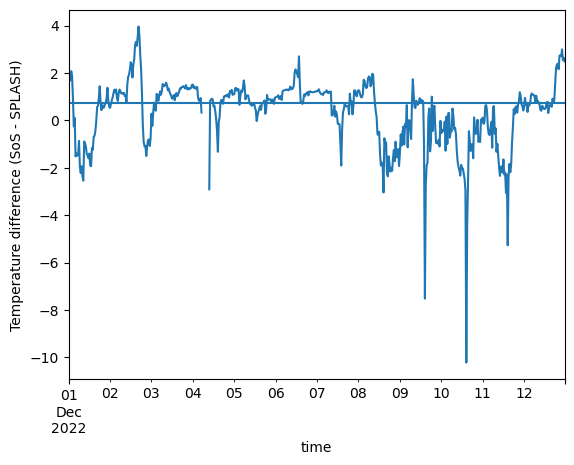

In [100]:
sos_minus_splash_Ts = ((sos_inputs_df['Tsurf_c'].loc['20221201': '20221212']) - 
    (splash_inputs_df['skin_temp_surface'].loc['20221201': '20221212']))
sos_minus_splash_Ts.plot()
plt.axhline(sos_minus_splash_Ts.median())
plt.ylabel("Temperature difference (SoS - SPLASH)")

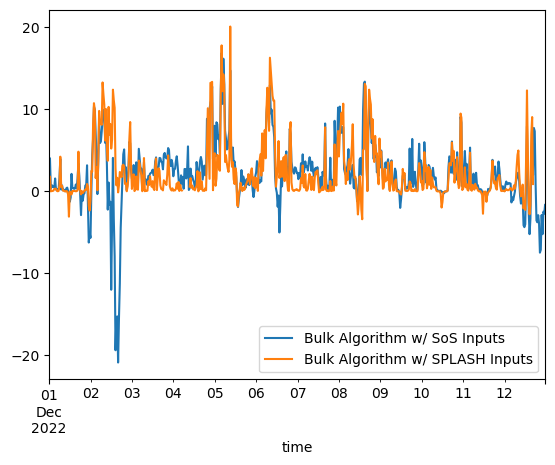

In [101]:
# (
#     sos_inputs_df['w_h2o__3m_c'] * latent_heat_of_vaporization
# ).loc['20221201': '20221212'].plot(label='SOS EC measurements')
(-sos_results_df['hlb']).loc['20221201': '20221212'].plot(label='Bulk Algorithm w/ SoS Inputs')
(-splash_results_df['hlb']).loc['20221201': '20221212'].plot(label='Bulk Algorithm w/ SPLASH Inputs')
# splash_inputs_df['bulk_Hl'].loc['20221201': '20221212'].plot(label='Provided SPLASH bulk calculations')
plt.legend()

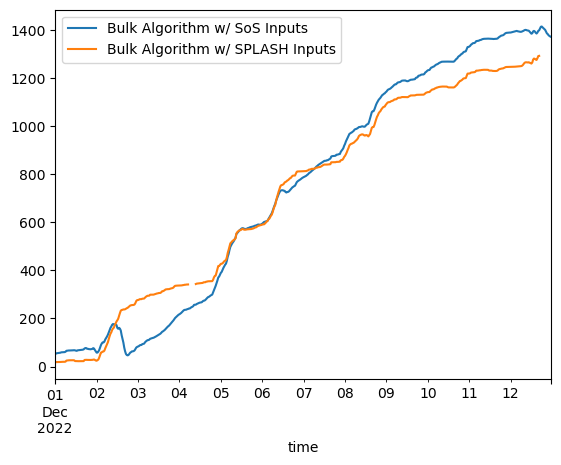

In [103]:
(-sos_results_df['hlb']).cumsum().loc['20221201': '20221212'].plot(label='Bulk Algorithm w/ SoS Inputs')
(-splash_results_df['hlb']).cumsum().loc['20221201': '20221212'].plot(label='Bulk Algorithm w/ SPLASH Inputs')
plt.legend(
)

In [50]:
sos_minus_splash_Hl = (
    (-sos_results_df['hlb']).loc['20221201': '20221212']
    -
    (-splash_results_df['hlb']).loc['20221201': '20221212']
)